https://github.com/tk-rusch/LEM

In [3]:
# run script LEM_cuda/example/FitzHughNagumo_task.py

%run LEM_cuda/example/FitzHughNagumo_task.py

Namespace(batch=32, device=device(type='cuda'), epochs=500, id=1, lr=0.01545927736419477, nhid=16, seed=1234)
Generating data
Finished generating data


NameError: name 'lem_cuda' is not defined

In [1]:
# %load src/FitzHughNagumo/data.py
from scipy import integrate
import numpy as np

def FHN_rhs(t,x):
    I = 0.5
    a = 0.7
    b = 0.8
    eps = 1./50.
    dim1 = x[0] - (x[0]**3)/3. - x[1] + I
    dim2 = eps*(x[0] + a - b*x[1])

    out = np.stack((dim1,dim2)).T

    return out

def get_data(N,T=1000):
    data_x = []
    data_y = []
    for i in range(N):
        t = np.linspace(0,400,T+1)
        x0 = np.array([float(np.random.rand(1))*2.-1.,0.])
        sol = integrate.solve_ivp(FHN_rhs, [0,400], x0, t_eval=t)
        data_x.append(sol.y[0,:-1])
        data_y.append(sol.y[0,1:])

    data_x = np.array(data_x)
    data_y = np.array(data_y)
    return data_x.reshape(N,T,1), data_y.reshape(N,T,1)


In [65]:
# %load LEM_cuda/example/network.py
import torch
import torch.nn as nn
import math

class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1.-ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1.-ms_dt_bar)* y + ms_dt_bar * torch.tanh(self.transform_z(z)+i_z)

        return y, z

class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp,nhid,dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        ## initialize hidden states
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        y_hidds = []
        for x in input:
            y, z = self.cell(x,y,z)
            y_hidds.append(y)
        out = self.classifier(torch.stack((y_hidds), dim=0))
        return out

In [10]:
from torch import nn, optim, Tensor
import torch
#import network
import torch.nn.utils
#import data
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset

In [11]:
# %load src/FitzHughNagumo/FitzHughNagumo_task.py

nhid = 16
epochs = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch = 32
lr = 0.00904
seed = 1234

ninp = 1
nout = 1

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)

train_x, train_y = get_data(128)
valid_x, valid_y = get_data(128)
test_x, test_y = get_data(1024)
print('Finished generating data')

## Train data:
train_dataset = TensorDataset(Tensor(train_x).float(), Tensor(train_y))
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=batch)

## Valid data
valid_dataset = TensorDataset(Tensor(valid_x).float(), Tensor(valid_y).float())
validloader = DataLoader(valid_dataset, shuffle=False, batch_size=128)

## Test data
test_dataset = TensorDataset(Tensor(test_x).float(), Tensor(test_y).float())
testloader = DataLoader(test_dataset, shuffle=False, batch_size=128)


model = LEM(ninp, nhid, nout).to(device)

objective = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

def eval(dataloader):
    model.eval()
    with torch.no_grad():
        for x,y in dataloader:
            y = y.permute(1, 0, 2)
            x = x.permute(1, 0, 2)
            out = model(x.to(device))
            loss = torch.sqrt(objective(out,y.to(device))).item()
    return loss

best_loss = 10000
for epoch in range(epochs):
    model.train()
    for x,y in trainloader:
        y = y.permute(1, 0, 2)
        x = x.permute(1, 0, 2)
        optimizer.zero_grad()
        out = model(x.to(device))
        loss = objective(out, y.to(device))
        loss.backward()
        optimizer.step()
    valid_loss = eval(validloader)
    test_loss = eval(testloader)
    if (valid_loss < best_loss):
        best_loss = valid_loss
        final_test_loss = test_loss

    Path('result').mkdir(parents=True, exist_ok=True)
    f = open('result/FitzHughNagumo_log2.txt', 'a')
    f.write('eval loss: ' + str(valid_loss) + '\n')
    print('eval loss: ' + str(valid_loss))
    f.close()

f = open('result/FitzHughNagumo_log2.txt', 'a')
f.write('final test loss: ' + str(final_test_loss) + '\n')
f.close()



Finished generating data
eval loss: 0.2712252140045166
eval loss: 0.2718495726585388
eval loss: 0.21670150756835938
eval loss: 0.19315138459205627
eval loss: 0.1425812542438507
eval loss: 0.14888741075992584
eval loss: 0.1027880534529686
eval loss: 0.11701568216085434
eval loss: 0.08183439075946808
eval loss: 0.09134981781244278
eval loss: 0.07010043412446976
eval loss: 0.07152237743139267
eval loss: 0.05959450826048851
eval loss: 0.060513608157634735
eval loss: 0.05317223072052002
eval loss: 0.053805213421583176
eval loss: 0.04992789030075073
eval loss: 0.049009811133146286
eval loss: 0.047154080122709274
eval loss: 0.045139119029045105
eval loss: 0.04417727515101433
eval loss: 0.04249360039830208
eval loss: 0.041299257427453995
eval loss: 0.04028400778770447
eval loss: 0.0390155129134655
eval loss: 0.038001660257577896
eval loss: 0.03702056035399437
eval loss: 0.03599631041288376
eval loss: 0.03508707135915756
eval loss: 0.034222561866045
eval loss: 0.03335505723953247
eval loss: 0.0

In [13]:
# save model
#torch.save(model.state_dict(), 'result/FitzHughNagumo_model2.pt')

In [40]:
# do inference 
model2 = LEM(ninp, nhid, nout).to(device)
model2.load_state_dict(torch.load('result/FitzHughNagumo_model2.pt'))
model2.eval()
i = 0
with torch.no_grad():
    for x,y in testloader:
        if i == 0:
            y = y.permute(1, 0, 2)
            x = x.permute(1, 0, 2)
            out = model2(x.to(device))
            print(out.shape)
            loss = torch.sqrt(objective(out,y.to(device))).item()
            print('test loss: ' + str(loss))
            i += 1

torch.Size([1000, 128, 1])
test loss: 0.0024121899623423815


In [38]:
# check shape of model output
print(out.shape)


torch.Size([1000, 128, 1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8
torch.Size([128, 1000, 1])
torch.Size([128, 1000, 1])


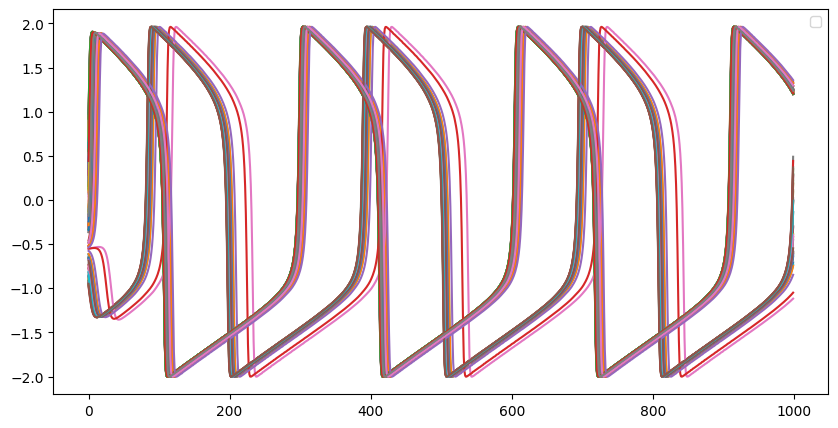

In [62]:

x,y = list(iter(testloader))[0]
print(x.shape)
print(y.shape)

from matplotlib import pyplot as plt

# plot x
plt.figure(figsize=(10, 5))
for i in range(128):
	plt.plot(x[i,0:,0].numpy())
#plt.plot(y[0,:,0].numpy(), label='y')
#plt.xlim(0, 10)
plt.legend()